# Project 1: Classification Analysis on Textual Data
In this project, we work with the “20 Newsgroups” dataset and manage to classify documents into two categories: "Computer Technology" and "Recreational Activity". By extracting significant features(TF_IDF) from documents, applying dimension reduction techniques(LSI and NMF) to high-dimensional feature vectors, and comparing the performance of various classifiers(SVM, Multinomial Naive Bayes and Logistic Regression) based on certain evaluation metrics(ROC Curve, Confusion Matrix, Recall and Precision Rates), we go over the entire procedure of classification on textual data, and furthermore, get a clear understanding of how hyper-parameters might affect the prediction results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### (a)

- Load the training and testing sets of 8 sub-classes:
> - Computer Technology: 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'
> - Recreational Activity: 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'

- Extract the actual data and labels

- Plot a histogram regarding the distribution of training documents among all sub-classes:
> From the histogram, we observe that the datasets are already balanced. Each category contains about 600 training documents.

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', \
              'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

# Raw data
X_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
X_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# Data fed into classifiers
data_train = X_train.data
data_test = X_test.data
label_train = (X_train.target > 3).astype(int)
label_test = (X_test.target > 3).astype(int)

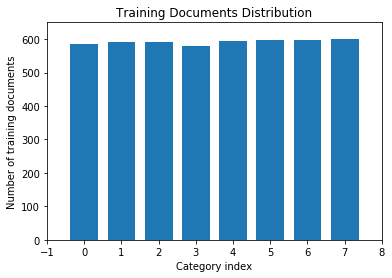

In [3]:
# Plot of document distribution
category_idx = X_train.target
plt.hist(category_idx, np.arange(-0.5, 8.5), rwidth=0.75)
plt.xlabel('Category index')
plt.ylabel('Number of training documents')
plt.title('Training Documents Distribution')
plt.axis([-1, 8, 0, 650])
plt.show()

### (b)

- Define stemming function:
> We apply the SnowBallStemmer() to get rid of terms with the same stems. And by including "stop_words='english'" in defining CountVectorizer(), we also exclude very common terms such as "for", "in" and so on.

- Convert the original data into the term-document matrix:
> CountVectorizer() can do this in a very clean and efficient way.

- Compute the TF_IDF feature matrix:
> TfidfTransformer() can do this in a very clean and efficient way.

- Compare different choices of "min_df":
> "min_df" represents the minimal qualification frequency of terms. If a term appears fewer times than "min_df" indicates, it will not be further considered. An initial comparison shows that when "min_df" is 2, there are 23059 terms left, and when "min_df" is 5, there are 9815 terms left. This result agrees with our expectation that as "min_df" gets larger, fewer terms remain to be considered. 

In [4]:
import nltk
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation

# Create our own stopwords set
stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en), set(punctuation), set(stop_words_skt))

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Define stemming function
analyzer = CountVectorizer().build_analyzer()
stemmer = nltk.stem.SnowballStemmer('english')
def stemmed_words(doc):
    return (stemmer.stem(word) for word in analyzer(doc) if word not in combined_stopwords and not word.isdigit())

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

# Get the term-document matrix under the condition: min_df=2
count_vect_2 = CountVectorizer(min_df=2, analyzer=stemmed_words)
X_train_counts = count_vect_2.fit_transform(data_train)
X_test_counts = count_vect_2.fit_transform(data_test)
print X_train_counts.shape

# Get the term-document matrix under the condition: min_df=5
count_vect = CountVectorizer(min_df=5, analyzer=stemmed_words)
X_train_counts = count_vect.fit_transform(data_train)
X_test_counts = count_vect.fit_transform(data_test)
print X_train_counts.shape

# Get the TF_IDF feature matrix
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

(4732, 23059)
(4732, 9815)


### (c)
- Load the training and testing sets of all sub-classes

- Construct the term-class matrix from the term-document matrix:
> For each class, we add feature vectors of documents corresponding to that class to form a new feature vector. And then, we stack all new feature vectors horizontally.

- Compute the TF_ICF feature matrix:
> This algorithm is exactly the same as the one we used to compute the TF_IDF feature matrix.

- Find the 10 most significant terms in concerned sub-classes:
> - Concerned sub-classes: 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian'
> - Here, we consider "significance" as an equivalence of frequency, i.e. a term is more significant if it shows up more often.
> - By running the code block below, four groups of terms will be returned. The result seems correct because terms like "edu", "scsi" and "univers(ity)" are more related to computer technology while "church", "christian" and "god" are more related to recreational(religious) activity.

In [7]:
categories_sub = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
idxs_sub = [3, 4, 6, 15]
X_ALL_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
X_ALL_train_counts = count_vect.fit_transform(X_ALL_train.data).toarray()

# Convert term-document into term-class matrix by adding the feature vectors of documents belonging to the same class
counts_by_category = []
num_docs = X_ALL_train_counts.shape[0]
num_terms = X_ALL_train_counts.shape[1]
for category_idx in np.arange(20):
    if category_idx == 0:
        counts_by_category = np.sum(X_ALL_train_counts[X_ALL_train.target==0], axis=0).reshape(1, num_terms)
    else:
        counts_by_category = np.vstack([counts_by_category, np.sum(X_ALL_train_counts[X_ALL_train.target==category_idx], axis=0).\
            reshape(1, num_terms)])

# Compute the TF_ICF feature matrix and present the top 10 words (in terms of frequency) in concerned categories
X_train_tficf = tfidf_transformer.fit_transform(counts_by_category).toarray()
for idx in idxs_sub:
    top_10 = np.argsort(X_train_tficf[idx, :])[-10:]
    top_10_words = [count_vect.get_feature_names()[i] for i in top_10]
    print top_10_words

[u'card', u'organ', u'subject', u'com', u'line', u'use', u'ide', u'edu', u'drive', u'scsi']
[u'scsi', u'simm', u'appl', u'use', u'quadra', u'organ', u'subject', u'line', u'mac', u'edu']
[u'use', u'univers', u'com', u'new', u'post', u'organ', u'subject', u'sale', u'line', u'edu']
[u'christ', u'say', u'line', u'peopl', u'subject', u'church', u'jesus', u'edu', u'christian', u'god']


### (d)
Before feeding data into classifiers, we need to reduce their dimensions so that we only keep the most valuable information of data. Here, we introduce two different dimension reduction techniques: LSI and NMF. We will compare them in following parts.<br>
We also introduce pipelines to simplify coding. By assembling key components including: CountVectorizer, TfidfTransformer, TruncatedSVD/NMF and classifiers, we no longer need to re-write everything for just a trivial alteration in the problem setting.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import LinearSVC

# Define two pipelines using different dimension reduction techniques
pipe_LSI = Pipeline([
    ('vect', CountVectorizer(min_df=5, analyzer=stemmed_words)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('clf', LinearSVC(C=10**3)),
])

pipe_NMF = Pipeline([
    ('vect', CountVectorizer(min_df=5, analyzer=stemmed_words)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(n_components=50, random_state=42)),
    ('clf', LinearSVC(C=10**3)),
])

Helper functions:
- plot_roc(): Plot ROC curve
- fit_predict_and_plot_roc_and_evaluate(): Evaluate classifiers

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, precision_score

# Plot the ROC curve based on TPR(True Positive Rate) and FPR(False Positive Rate)
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

# Evaluate a classifier based on metrics including: ROC curve, confusion matrix, recall and precision rates and accuracy
def fit_predict_and_plot_roc_and_evaluate(pipe, classifier, isBinary, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    pred_result = pipe.predict(test_data)
    # SVM does not support predict_proba() method
    if (classifier == "SVM"):
        prob_score = pipe.decision_function(test_data)
    else:
        prob_score = pipe.predict_proba(test_data)[:, 1]
    
    if (classifier == "LogisticRegression"):
        print pipe.named_steps['clf'].coef_
    
    # Only plot ROC curves for binary classification problems
    if (isBinary == True):
        fpr, tpr, _ = roc_curve(test_label, prob_score)

        plot_roc(fpr, tpr)
    
    # Confusion matrix
    confusion = confusion_matrix(test_label, pred_result)
    # Accuracy
    acc = accuracy_score(test_label, pred_result)
    # Recall and precision rates
    if (isBinary == True):
        rec = recall_score(test_label, pred_result)
        pre = precision_score(test_label, pred_result)
    else:
        rec = recall_score(test_label, pred_result, average='weighted')
        pre = precision_score(test_label, pred_result, average='weighted')  
    
    # Print out results
    print confusion, acc, rec, pre
    return pipe

### (e)
Apply Linear SVC to classify.

- Compare hard margin linear SVCs with different "min_df":
> Hard margin SVMs refer to those assign more weights on mis-classification penalty, and less on regularization term.
> We explore the effect of "min_df" on hard margin SVMs under the settings "Hard Margin Linear SVC, min_df=5, LSI" and "Hard Margin Linear SVC, min_df=2, LSI". From the results below, we notice that "min_df" = 2 is better since it achieves a slightly higher accuracy. But overall, "min_df" does not have any significant effect on predictions by hard margin SVMs.
> - "min_df" = 5: acc - 0.971, rec - 0.989, pre - 0.956, conf_mx = [1487 73; 18 1582]
> - "min_df" = 2: acc - 0.974, rec - 0.980, pre - 0.970, conf_mx = [1511 49; 32 1568]

- Compare soft margin linear SVCs with different "min_df":
> Soft margin SVMs refer to those assign more weights on regularization terms, and less on mis-classification penalty.
> We explore the effect of "min_df" on soft margin SVMs under the settings "Soft Margin Linear SVC, min_df=5, LSI" and "Soft Margin Linear SVC, min_df=2, LSI". From the results below, we notice that "min_df" = 5 is better since it achieves a slightly higher accuracy. But overall, "min_df" does not have any significant effect on predictions by soft margin SVMs too.
> - "min_df" = 5: acc - 0.942, rec - 0.995, pre - 0.900, conf_mx = [1384 176; 8 1582]
> - "min_df" = 2: acc - 0.937, rec - 0.995, pre - 0.892, conf_mx = [1369 191; 8 1582]

- Compare hard margin linear SVCs vs. soft margin linear SVCs:
> We explore the effect of tradeoff parameter on SVMs under the settings "Hard Margin Linear SVC, min_df=5, LSI" and "Soft Margin Linear SVC, min_df=5, LSI". From the results below, we notice that hard margin SVMs achieve better accuracy and precision rate than soft margin SVMs, while their recall rates are similar. This means that in this case, giving too much weight to the regularization term may degrade the performance of SVMs.
> - Hard margin: acc - 0.971, rec - 0.989, pre - 0.956, conf_mx = [1487 73; 18 1582]
> - Soft margin: acc - 0.942, rec - 0.995, pre - 0.900, conf_mx = [1384 176; 8 1582]

- Compare LSI and NMF:
> We explore the effect of different dimension reduction techniques under the settings "Hard Margin Linear SVC, min_df=5, LSI" and "Hard Margin Linear SVC, min_df=5, NMF". From the results below, we notice that applying LSI achieves far better accuracy and precision rate than applying NMF, while their recall rates are similar. While using NMF, although most positive examples are well classified, a lot of negative examples are predicted as positive too. This is not desired.
> - LSI: acc - 0.971, rec - 0.989, pre - 0.956, conf_mx = [1487 73; 18 1582]
> - NMF: acc - 0.907, rec - 0.997, pre - 0.847, conf_mx = [1273 287; 5 1585]

[[1499   61]
 [  21 1569]] 0.9739682539682539 0.9867924528301887 0.9625766871165644


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

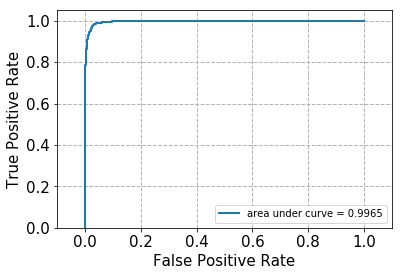

In [11]:
# Hard Margin Linear SVC, min_df=5, LSI
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "SVM", True, data_train, label_train, data_test, label_test)

[[1545   15]
 [ 132 1458]] 0.9533333333333334 0.9169811320754717 0.9898167006109979


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=2, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

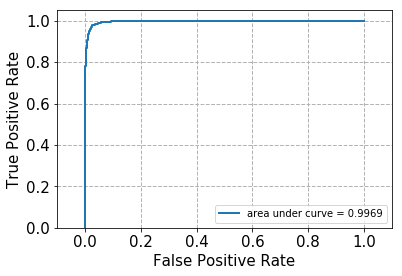

In [12]:
# Hard Margin Linear SVC, min_df=2, LSI
pipe_LSI.set_params(vect=CountVectorizer(min_df=2, analyzer=stemmed_words))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "SVM", True, data_train, label_train, data_test, label_test)

[[1384  176]
 [   8 1582]] 0.9415873015873016 0.9949685534591195 0.8998862343572241


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

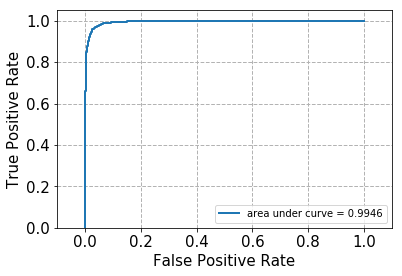

In [13]:
# Soft Margin Linear SVC, min_df=5, LSI
pipe_LSI.set_params(vect=CountVectorizer(min_df=5, analyzer=stemmed_words), clf=LinearSVC(C=10**-3))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "SVM", True, data_train, label_train, data_test, label_test)

[[1369  191]
 [   8 1582]] 0.9368253968253968 0.9949685534591195 0.892272983643542


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=2, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

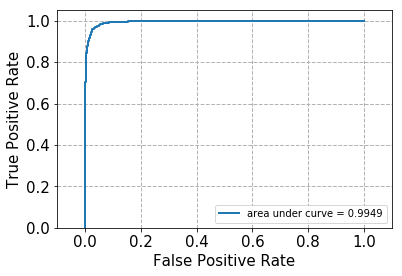

In [14]:
# Soft Margin Linear SVC, min_df=2, LSI
pipe_LSI.set_params(vect=CountVectorizer(min_df=2, analyzer=stemmed_words))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "SVM", True, data_train, label_train, data_test, label_test)

[[1516   44]
 [  85 1505]] 0.959047619047619 0.9465408805031447 0.9715945771465462


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

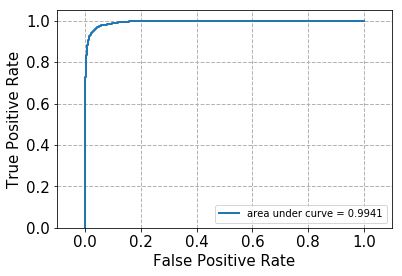

In [15]:
# Hard Margin Linear SVC, NMF
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "SVM", True, data_train, label_train, data_test, label_test)

[[  27 1533]
 [   0 1590]] 0.5133333333333333 1.0 0.5091258405379443


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

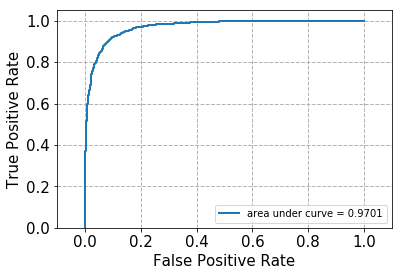

In [16]:
# Soft Margin Linear SVC, NMF
pipe_NMF.set_params(clf=LinearSVC(C=10**-3))
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "SVM", True, data_train, label_train, data_test, label_test)

### (f)
- Cross-validate(5-fold) to find the optimal regularization coefficient:
> We select the optimal regularization coefficient from the set {10^k|-3<=k<=3} by evaluating cross_val_score() based on various regularization coefficients. According to our experiments, the optimal regularization coefficients for SVM using LSI and SVM using NMF are both 100. When we compare the results here with previous results, we find out that C=100 does give better results than either C=1000 or C=0.001. Especially for NMF, the boosting effect of choosing C=100 is tremendous.

- Compare LSI and NMF:
> We explore the effect of different dimension reduction techniques under the settings "Fine-tuned Linear SVC, min_df=5, LSI" and "Fine-tuned Linear SVC, min_df=5, NMF". From the results below, we notice that applying LSI achieves better accuracy, recall and precision rates than applying NMF. But its performance advantage is not that obvious like the cases C=1000 or C=0.001, implying that a proper regularization coefficient can have huge effect on NMF.
> - LSI: acc - 0.976, rec - 0.983, pre - 0.969, conf_mx = [1510 50; 27 1563]
> - NMF: acc - 0.959, rec - 0.967, pre - 0.953, conf_mx = [1485 75; 53 1537]

In [17]:
from sklearn.model_selection import cross_val_score

num_folds = 5
exponents = np.linspace(-3, 3, num=7)
LSI_score = []
NMF_score = []

# 5-fold cross validation to find the best exponent, which achieves the highest score
LSI_dim_reductor = TruncatedSVD(n_components=50, random_state=42)
NMF_dim_reductor = NMF(n_components=50, random_state=42)
LSI_feature = LSI_dim_reductor.fit_transform(X_train_tfidf)
NMF_feature = NMF_dim_reductor.fit_transform(X_train_tfidf)
for ex in exponents:
    this_svm = LinearSVC(C=10**ex)
    LSI_score = np.append(LSI_score, np.mean(cross_val_score(this_svm, LSI_feature, label_train, cv=num_folds)))
    NMF_score = np.append(NMF_score, np.mean(cross_val_score(this_svm, NMF_feature, label_train, cv=num_folds)))

LSI_best = 10 ** exponents[np.argmax(LSI_score)]
NMF_best = 10 ** exponents[np.argmax(NMF_score)]
print LSI_best, NMF_best

10.0 100.0


[[1512   48]
 [  29 1561]] 0.9755555555555555 0.9817610062893082 0.9701678060907396


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

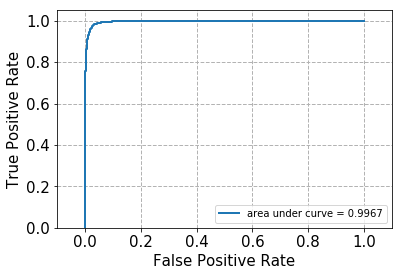

In [18]:
# Fine-tuned Linear SVC, min_df=5, LSI
pipe_LSI.set_params(vect=CountVectorizer(min_df=5, analyzer=stemmed_words), clf=LinearSVC(C=LSI_best))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "SVM", True, data_train, label_train, data_test, label_test)

[[1512   48]
 [  30 1560]] 0.9752380952380952 0.9811320754716981 0.9701492537313433


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=2, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

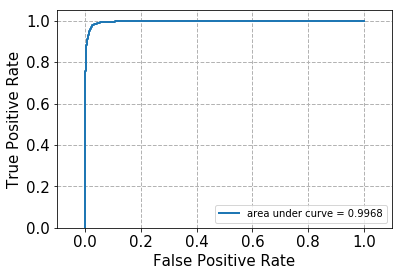

In [19]:
# Fine-tuned Linear SVC, min_df=2, LSI
pipe_LSI.set_params(vect=CountVectorizer(min_df=2, analyzer=stemmed_words))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "SVM", True, data_train, label_train, data_test, label_test)

[[1488   72]
 [  54 1536]] 0.96 0.9660377358490566 0.9552238805970149


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

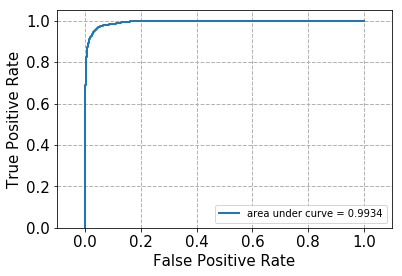

In [20]:
# Fine-tuned Linear SVC, min_df=5, NMF
pipe_NMF.set_params(clf=LinearSVC(C=NMF_best))
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "SVM", True, data_train, label_train, data_test, label_test)

### (g)
Apply Multinomial Naive Bayes to classify.

- Compare between Multinomial Naive Bayes and SVMs:
> Since Multinomial Naive Bayes from sklearn only support non-negative input matrices, we can only use NMF in this case. 
> We explore the effect of different types of classifier under the settings "Multinomial Naive Bayes, min_df=5, NMF" and "Fine-tuned Linear SVC, min_df=5, NMF". From the results below, we notice that SVMs achieve better accuracy and precision rate than Multinomial Naive Bayes classifiers, while their recall rates are similar. Perhaps this implies the built-in SVMs are more appropriate than Multinomial Naive Bayes classifiers for binary classification problems.
> - Multinomial Naive Bayes: acc - 0.919, rec - 0.970, pre - 0.882, conf_mx = [1353 207; 47 1543]
> - SVM: acc - 0.959, rec - 0.967, pre - 0.953, conf_mx = [1485 75; 53 1537]

[[1353  207]
 [  47 1543]] 0.9193650793650794 0.970440251572327 0.8817142857142857


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...cd', tol=0.0001,
  verbose=0)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

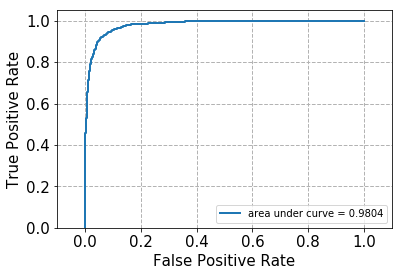

In [21]:
from sklearn.naive_bayes import MultinomialNB

# Multinomial Naive Bayes, min_df=5, NMF
pipe_NMF.set_params(vect=CountVectorizer(min_df=5, analyzer=stemmed_words), clf=MultinomialNB())
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "NaiveBayes", True, data_train, label_train, data_test, label_test)

### (h)
Apply Logistic Regression to classify.

- Compare among Logistic Regression, SVMs and Multinomial Naive Bayes:
> In this part, our Logistic Regression classifier does not include the regularization term. We achieve this by assigning "C" na extremely large value.
> We explore the effect of different types of classifier under the settings "Logistic Regression, min_df=5, NMF", "Fine-tuned Linear SVC, min_df=5, NMF" and "Multinomial Naive Bayes, min_df=5, NMF". From the results below, we notice that SVMs achieve the highest accuracy. But overall, they perform similarly to Logistic Regression classifiers. Both of them are far better than Multinomial Naive Bayes classifiers.
> - Logistic Regression: acc - 0.962, rec - 0.966, pre - 0.959, conf_mx = [1494 66; 54 1536]
> - SVM: acc - 0.959, rec - 0.967, pre - 0.953, conf_mx = [1485 75; 53 1537]
> - Multinomial Naive Bayes: acc - 0.919, rec - 0.970, pre - 0.882, conf_mx = [1353 207; 47 1543]

- Compare Logistic Regression with different "min_df":
> We explore the effect of "min_df" on Logistic Regression classifiers under the settings "Logistic Regression, min_df=5, LSI" and "Logistic Regression, min_df=2, LSI". From the results below, we notice that varying "min_df" does not significantly influence the predictability of Logistic Regression classifiers, meaning that in this case, the effect of "min_df" is very trivial.
> - "min_df" = 5: acc - 0.974, rec - 0.982, pre - 0.967, conf_mx = [1506 54; 28 1562]
> - "min_df" = 2: acc - 0.974, rec - 0.981, pre - 0.968, conf_mx = [1509 51; 31 1559]

- Compare LSI and NMF:
> We explore the effect of different dimension reduction techniques under the settings "Logistic Regression, min_df=5, LSI" and "Logistic Regression, min_df=5, NMF". From the results below, we notice that applying LSI achieves better accuracy, recall and precision rates than applying NMF. This almost agrees with our previous conclusion about experiments on SVMs. Therefore, we can guess that LSI retains more valuable information about original data than NMF does.
> - LSI: acc - 0.974, rec - 0.982, pre - 0.967, conf_mx = [1506 54; 28 1562]
> - NMF: acc - 0.962, rec - 0.966, pre - 0.959, conf_mx = [1494 66; 54 1536]

[[-7.32265460e+00  1.18143917e+02  5.92180878e+01 -5.06991966e+01
  -3.14085101e+00 -3.44648534e+01 -1.44982957e+01  7.54921452e+00
   4.57523314e+01  2.75412968e+00  3.17656714e+00 -3.43343300e-01
   5.23770593e+00  8.43864777e+00  1.43797554e+01 -4.30518570e+00
  -2.40067660e+01  1.18191764e+01  7.56255275e+00  3.75077300e+00
   1.35869112e+01  3.95449900e-02 -9.77894948e+00 -8.84544581e+00
  -7.06011469e+00  1.23963898e+01  4.74484945e+00 -3.45958579e+00
  -1.10678278e-01 -1.42598822e+01  2.70060766e-03 -7.34311154e+00
   1.18261531e+01 -2.60467044e+00 -1.00807107e+01 -5.27225975e+00
   6.22165796e+00  1.51481687e+01  2.36602992e+00 -2.90825721e+00
  -1.00178297e+00 -1.47175182e+00  1.81392108e+01  1.48370721e+01
  -1.51941372e+00 -3.53636685e+00  4.80776232e+00 -8.67789664e+00
  -2.59911673e+00  3.87474950e+00]]
[[1506   54]
 [  28 1562]] 0.9739682539682539 0.9823899371069182 0.9665841584158416


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

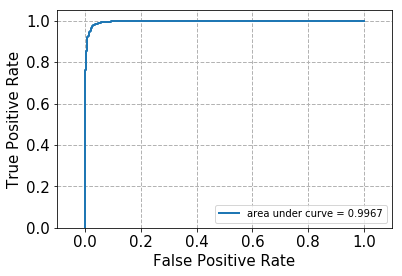

In [22]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression, min_df=5, LSI, without regularization
pipe_LSI.set_params(vect=CountVectorizer(min_df=5, analyzer=stemmed_words), clf=LogisticRegression(C=10**6))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "LogisticRegression", True, data_train, label_train, data_test, label_test)

[[ -3.80439842 131.56208249 -26.55751678  87.40021097  -4.93447814
  -42.40803388  -7.93602235  -5.07587138  33.06996466  15.62750689
   27.2295058    3.61455048 -17.20855056  12.88264325  12.1714216
   -0.25475001 -31.08892758  -1.91483578   7.1004863   -3.79628479
    2.62537171  -3.49057029  -2.61220533   4.58689222 -11.19036146
   -7.94960306  19.79237492  -8.38269552   7.33101998   4.52833429
    2.50448198 -14.4704136    7.09037335 -12.83932976   4.46389947
   -4.16432599   0.39241539  -0.37768647   9.49441713  14.88277785
   -0.27488613  -0.52715039  15.29943608  17.14945397  -2.64173979
    4.72506984   1.60619227  -5.68028078  14.79622493   3.95155809]]
[[1509   51]
 [  31 1559]] 0.9739682539682539 0.980503144654088 0.9683229813664597


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=2, ngram_range=(1, 1), preprocessor=N...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

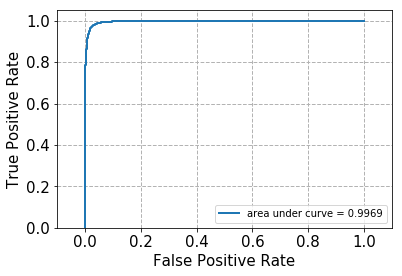

In [23]:
pipe_LSI.set_params(vect=CountVectorizer(min_df=2, analyzer=stemmed_words))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "LogisticRegression", True, data_train, label_train, data_test, label_test)

[[-329.52640243   82.87289868  395.63148496  -85.6785146    25.12296134
  -111.93708705   24.29915474  226.98450293  -97.42545049 -212.28307622
    24.73780102 -225.13566741   43.71723597   -8.54999077   81.20743285
    -7.74210783 -112.60925531  259.23537975    2.26791305    5.79632227
    40.34324401  -88.57848336   30.59224989   10.41559329 -243.04607605
    38.05724793   15.21705661  -19.6120553   -19.97147389 -168.67013907
     0.97683661   47.23274953 -136.44737089  -27.19067152   47.31971152
     1.21829697   19.11307299 -105.62772      54.37322123  -31.11935824
   -58.66508155  -96.71312908   31.04024392   47.55752411   23.75015634
    68.51664613    8.36697625   32.81148387   -1.44390265   11.38782412]]
[[1494   66]
 [  54 1536]] 0.9619047619047619 0.9660377358490566 0.9588014981273408


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

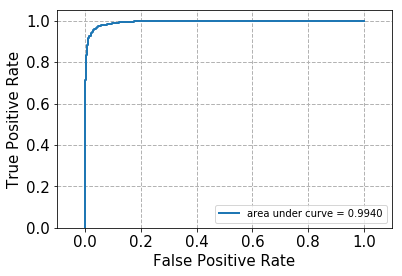

In [24]:
# Logistic Regression, min_df=5, NMF, without regularization
pipe_NMF.set_params(clf=LogisticRegression(C=10**6))
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "LogisticRegression", True, data_train, label_train, data_test, label_test)

### (i)

- Compare the effect of l2-norm/l1-norm on testing error:
> We explore the effect of l2-norm/l1-norm on testing error under the settings "Logistic Regression, min_df=5, LSI, l2-norm regularization" and Logistic Regression, min_df=5, LSI, l1-norm regularization. From the results below, we notice that l2-norm achieves a slightly better accuracy, recall and precision rates than l1-norm, but their differences are trivial. Hence, different choices of norm do not siginificantly influence the testing error.
> - l2-norm: acc - 0.969, rec - 0.979, pre - 0.961, conf_mx = [1496 64; 33 1557]
> - l1-norm: acc - 0.968, rec - 0.977, pre - 0.960, conf_mx = [1495 65; 36 1554]

- Compare the effect of l2-norm/l1-norm on learnt coefficients of fitted hyperplane:
> We explore the effect of l2-norm/l1-norm on learnt coefficients of fitted hyperplane under the settings "Logistic Regression, min_df=5, LSI, l2-norm regularization" and Logistic Regression, min_df=5, LSI, l1-norm regularization. By printing out the coefficients, we notice that all of l2-norm's coefficient are nonzero, while most of l1-norm's coefficients are zero. This results from the properties of l2-norm and l1-norm. <br>
> If we only want to keep dimensions with the strongest effect on samples(the coefficients on those dimensions have large absolute value), then we should use l1-norm. Otherwise, we should use l2-norm.
> - l2-norm: All coefficients are nonzero
> - l1-norm: Most coefficients are zero

- Compare LSI and NMF:
> We explore the effect of different dimension reduction techniques under the settings "Logistic Regression, min_df=5, LSI, l2-norm regularization" and "Logistic Regression, min_df=5, NMF, l2-norm regularization". From the results below, we notice that applying LSI achieves better accuracy, recall and precision rates than applying NMF. This agrees with our previous conclusion about experiments on Logistic Regression classifiers without regularization.
> - LSI: acc - 0.969, rec - 0.979, pre - 0.961, conf_mx = [1496 64; 33 1557]
> - NMF: acc - 0.915, rec - 0.953, pre - 0.887, conf_mx = [1366 194; 74 1516]

[[-9.82296745e-01  2.43939959e+01  1.05291168e+01 -7.61652294e+00
  -1.21268896e+00 -3.38239915e+00 -3.23845368e+00  1.90720830e-01
   7.37423485e+00 -2.00990271e-01  6.63679204e-01 -1.12927473e+00
   3.00527818e-01  9.06235041e-02  1.81889195e+00 -3.79241552e-01
  -2.05040879e+00  2.01309765e+00  1.11530834e+00  8.34377090e-01
   1.50158470e+00  6.38245762e-01 -3.49914784e-01 -1.65457611e+00
   2.04606654e-01  9.66742730e-01 -8.29473792e-01 -5.81893213e-01
  -5.54400403e-01 -2.35322793e+00 -2.12160474e-01 -2.43592503e-01
   9.99234451e-01 -7.95592721e-01 -3.05938304e-01 -3.34975903e-01
  -9.11549709e-01  8.34794021e-01  3.84124389e-01 -1.11153224e-01
  -7.18242945e-01  8.21370020e-01  1.83336752e+00  1.20147707e+00
  -1.00009285e+00  2.06333857e-01 -3.15898321e-01 -8.72181669e-03
  -5.00737185e-01 -2.94287799e-01]]
[[1496   64]
 [  33 1557]] 0.9692063492063492 0.9792452830188679 0.9605181986428131


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

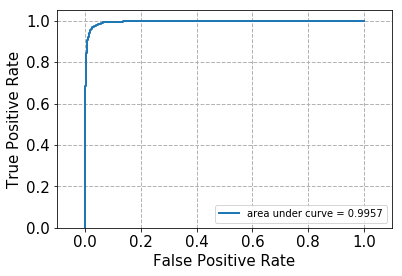

In [25]:
# Logistic Regression, min_df=5, LSI, l2-norm regularization
pipe_LSI.set_params(vect=CountVectorizer(min_df=5, analyzer=stemmed_words), clf=LogisticRegression(penalty='l2'))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "LogisticRegression", True, data_train, label_train, data_test, label_test)

[[-3.08039906  5.87429512  5.8976537  -4.08722674 -0.87360487 -7.04614407
   1.57420621  7.13012277 -3.32673152 -4.41294221  1.82956374 -3.69971791
   1.22678011 -1.66428642  4.95566686 -1.38115681 -2.93315052  3.97169662
   0.66918275  2.00581013  0.97528921 -6.62926946  2.50969676  1.30742419
  -4.27549968  3.10382045  1.1701523  -1.86781626 -1.63826291 -3.42621176
   0.24966271  2.48110386 -5.95579471 -2.41961317  3.31383399 -0.17605718
   1.99330952 -7.61702274  2.91286879 -3.22950896 -6.1816285  -5.03021943
   2.96086397  3.13696118  3.30225585  7.21027568  0.46756066  3.56685881
  -1.18709585  2.63015982]]
[[1366  194]
 [  74 1516]] 0.9149206349206349 0.9534591194968554 0.8865497076023392


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

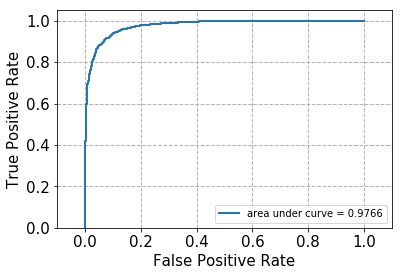

In [26]:
# Logistic Regression, min_df=5, NMF, l2-norm regularization
pipe_NMF.set_params(clf=LogisticRegression(penalty='l2'))
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "LogisticRegression", True, data_train, label_train, data_test, label_test)

[[  0.          72.44373963  30.87820293 -21.34107033  -0.570343
  -10.88312145  -4.93315764   0.          20.28573994   0.
    0.26614665   0.           0.           0.           0.
   -0.53432782  -6.98517921   0.           0.71374819   0.
    4.1285672    0.           0.          -0.87804414  -1.99929195
    1.95810941   0.           0.           0.          -2.17709777
    0.           0.           2.07248512   0.           0.
    0.           0.           3.45804642   0.           0.
    0.           0.           5.6437754    3.78090005   0.
    0.           0.           0.           0.           0.        ]]
[[1495   65]
 [  36 1554]] 0.967936507936508 0.9773584905660377 0.9598517603458925


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

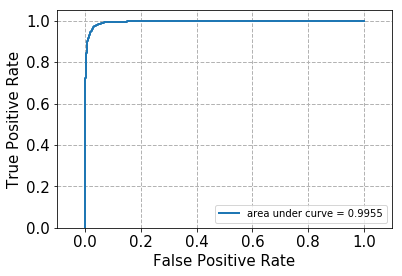

In [27]:
# Logistic Regression, min_df=5, LSI, l1-norm regularization
pipe_LSI.set_params(clf=LogisticRegression(penalty='l1'))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "LogisticRegression", True, data_train, label_train, data_test, label_test)

[[-45.08814074  34.58372076  71.35551351 -11.73836092   0.
  -39.68422359   0.          67.44851576 -12.77566192 -25.6928318
    1.82363576 -42.93770288   0.          -0.9267947   31.68255931
   -1.34846713  -7.31804987  30.18229814   0.           0.
    0.         -35.59864498   5.08500617   0.         -26.43359365
    9.23877385   0.          -3.24263482  -3.23914528 -22.67656827
    0.           5.39281313 -37.08199172  -5.16229653   7.93307484
    0.           4.05426094 -50.06522763   5.72815853  -7.7898128
  -21.85216068 -17.49378052   6.17221158   6.81218389   6.27953471
   29.19956744   0.           7.90095659   0.           3.24999279]]
[[1468   92]
 [  57 1533]] 0.9526984126984127 0.9641509433962264 0.9433846153846154


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

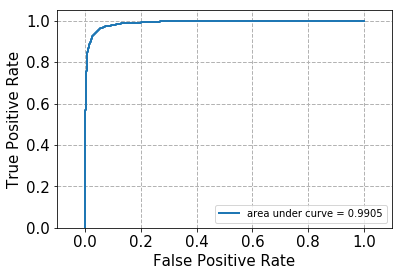

In [28]:
# Logistic Regression, min_df=5, NMF, l1-norm regularization
pipe_NMF.set_params(clf=LogisticRegression(penalty='l1'))
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "LogisticRegression", True, data_train, label_train, data_test, label_test)

### (j)
Apply multiclass classification.

- Load the training and testing sets of 4 sub-classes:
> Concerned categories: 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian'

- Extract the actual data and labels

- Compare among Multinomial Naive Bayes, SVM - OneVsOne and SVM - OneVsRest:
> We explore the effect of different types of multiclass classifier under the settings "Multiclass Multinomial Naive Bayes, min_df=5, NMF", "Multiclass Linear SVC(ovo), min_df=5, NMF" and "Multiclass Linear SVC(ovr), min_df=5, NMF". From the results below, we notice that SVMs - OneVsRest achieve the highest accuracy, recall and precision rates. But overall, they perform similarly to SVMs - OneVsOne. Both of them are far better than Multinomial Naive Bayes classifiers.
> - Multinomial Naive Bayes: acc - 0.774, rec - 0.774, pre - 0.783, conf_mx = [308 22 56 6; 91 228 60 6; 62 19 285 24; 0 0 7 391]
> - SVM - OneVsOne: acc - 0.846, rec - 0.846, pre - 0.848, conf_mx = [316 48 25 3; 61 296 26 2; 39 22 326 3; 9 1 2 386]
> - SVM - OneVsRest: acc - 0.848, rec - 0.848, pre - 0.849, conf_mx = [310 57 22 3; 62 296 25 2; 33 21 333 3; 7 2 1 388]

- Compare LSI and NMF:
> We explore the effect of different dimension reduction techniques under the settings "Multiclass Linear SVC(ovo), min_df=5, LSI, min_df=5, LSI" and "Multiclass Linear SVC(ovo), min_df=5, NMF". From the results below, we notice that applying LSI achieves better accuracy, recall and precision rates than applying NMF. This agrees with our previous conclusion about experiments on SVMs and Logistic Regression classifiers.
> - LSI: acc - 0.886, rec - 0.886, pre - 0.886, conf_mx = [329 40 22 1; 34 323 28 0; 23 25 341 1; 4 0 0 394]
> - NMF: acc - 0.846, rec - 0.846, pre - 0.848, conf_mx = [316 48 25 3; 61 296 26 2; 39 22 326 3; 9 1 2 386]

In [29]:
# Raw data
X_train_sub = fetch_20newsgroups(subset='train', categories=categories_sub, shuffle=True, random_state=42)
X_test_sub = fetch_20newsgroups(subset='test', categories=categories_sub, shuffle=True, random_state=42)

# Data fed into classifiers
data_train_sub = X_train_sub.data
data_test_sub = X_test_sub.data
label_train_sub = X_train_sub.target
label_test_sub = X_test_sub.target

In [30]:
# Multiclass Multinomial Naive Bayes, min_df=5, NMF
pipe_NMF.set_params(clf=MultinomialNB())
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "NaiveBayes", False, data_train_sub, label_train_sub, data_test_sub, label_test_sub)

[[308  22  56   6]
 [ 91 228  60   6]
 [ 62  19 285  24]
 [  0   0   7 391]] 0.7744408945686901 0.7744408945686901 0.7828059776238976


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...cd', tol=0.0001,
  verbose=0)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [31]:
from sklearn.multiclass import OneVsOneClassifier

# Multiclass Linear SVC(ovo), min_df=5, LSI
pipe_LSI.set_params(clf=OneVsOneClassifier(LinearSVC(C=NMF_best)))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "SVM", False, data_train_sub, label_train_sub, data_test_sub, label_test_sub)

[[329  40  22   1]
 [ 34 323  28   0]
 [ 23  25 341   1]
 [  4   0   0 394]] 0.886261980830671 0.886261980830671 0.8864584875619922


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])

In [32]:
# Multiclass Linear SVC(ovo), min_df=5, NMF
pipe_NMF.set_params(clf=OneVsOneClassifier(LinearSVC(C=NMF_best)))
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "SVM", False, data_train_sub, label_train_sub, data_test_sub, label_test_sub)

[[316  48  25   3]
 [ 61 296  26   2]
 [ 37  22 328   3]
 [  8   1   3 386]] 0.8472843450479233 0.8472843450479233 0.8490997749960966


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])

In [33]:
# Multiclass Linear SVC(ovr), min_df=5, LSI
pipe_LSI.set_params(clf=LinearSVC(C=LSI_best))
fit_predict_and_plot_roc_and_evaluate(pipe_LSI, "SVM", False, data_train_sub, label_train_sub, data_test_sub, label_test_sub)

[[314  51  26   1]
 [ 28 327  30   0]
 [ 22  18 346   4]
 [  3   0   1 394]] 0.8824281150159744 0.8824281150159744 0.8825287881463091


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [34]:
# Multiclass Linear SVC(ovr), min_df=5, NMF
pipe_NMF.set_params(clf=LinearSVC(C=NMF_best))
fit_predict_and_plot_roc_and_evaluate(pipe_NMF, "SVM", False, data_train_sub, label_train_sub, data_test_sub, label_test_sub)

[[311  56  22   3]
 [ 63 295  25   2]
 [ 33  21 333   3]
 [  7   2   1 388]] 0.8479233226837061 0.8479233226837061 0.8491857113302271


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x10e74eb18>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=5, ngram_range=(1, 1), preprocessor=N...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])